# Data Visualization and Metrics on the CelebA_HQ Dataset

In [7]:
import pandas as pd
import sklearn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Populate Dataframes

Each dataframe consists of 5 columns: `image`, `image_path`, `actual_label`, `predicted_label`, `confidence`
* `image` is the image name, for example 10.jpg
* `image_path` is the path to the image
* `actual_label` is the actual label for that person (the original image)
* `predicted_label` is the result of running the original, attacked, or defended image into the classifier. This is the label used to determine if the attack or defense was effective.
* `confidence` is the confidence in which we think that the image belongs to that class. This is the max value of the prediction.

In [8]:
fgsm05_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM05.csv")
fgsm05_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM05.csv")
fgsm05_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM05-detected.csv")

fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm25_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM25.csv")
fgsm25_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM25.csv")
fgsm25_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM25-detected.csv")

fgsm50_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM50.csv")
fgsm50_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM50.csv")
fgsm50_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM50-detected.csv")

pgd1010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD1010.csv")
pgd1010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD1010.csv")
pgd1010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD1010-detected.csv")

pgd2010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD2010.csv")
pgd2010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2010.csv")
pgd2010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD2010-detected.csv")

pgd5050_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/PGD5050.csv")
pgd5050_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD5050.csv")
pgd5050_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-PGD5050-detected.csv")

jitter1010_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/Jitter1010.csv")
jitter1010_defend_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-Jitter1010.csv")
jitter1010_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-Jitter1010-detected.csv")

test_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/test.csv")
test_defended_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test.csv")
test_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-detected.csv")

## Defense Metrics

In [9]:
def print_test_metrics(test_df, test_defended_df, test_detected_df):
   test_defended_df["predicted_label_test"] = test_df["predicted_label"]
   
   face_detection = pd.merge(test_detected_df, test_defended_df, on=['image'], how='inner').drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y', 'image_path_y',
   'actual_label', 'predicted_label', 'confidence'])

   defense_df = pd.merge(test_detected_df, test_defended_df, on=['image'], how='outer')
   defense_df = defense_df[defense_df.isna().any(axis=1)].drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y'])
   defense_df = defense_df.rename(columns={'image_path_y': 'image_path'})

   accuracy_orig_df = test_df[test_df["actual_label"] == test_df["predicted_label"]]   
   accuracy_df = defense_df[defense_df["predicted_label_test"] == defense_df["predicted_label"]]
   
   total_images = len(test_df)
   total_defendable_images = len(defense_df)

   accuracy = len(accuracy_df) / total_defendable_images * 100
   accuracy_orig = len(accuracy_orig_df) / total_images * 100
   # accuracy on classifier
   print(f"Accuracy of classifier on original test set {accuracy_orig:.2f}%")
   # A = C
   print(f"Accuracy on StyleCLIP-test {accuracy:.2f}%")


   # img 19 = acutal_label: 5
   # classifier(img 19) = predicted_label : 20

   # classifier(styleClIP(img 19)) = predicted_label : 20
   # compare(styleCLIP(img 19), predicted_label)
   # - does 20 = 20? 

In [10]:
print_test_metrics(test_df, test_defended_df, test_detected_df)

Accuracy of classifier on original test set 81.41%
Accuracy on StyleCLIP-test 68.53%


### Defense Metrics

In [13]:
def print_defense_metrics(attackname, attack_df, defense_df, detected_df, test_df=test_df, test_defended_df=test_defended_df, use_predicted=True):
   total_images = len(attack_df)

   # Add predicted_labels of the test set to adjust for innate classifier errors since classifier is only 80% accurate.
   attack_df["predicted_label_test"] = test_df["predicted_label"]
   defense_df["predicted_label_test"] = test_df["predicted_label"]

   label_comp = "actual_label"
   if use_predicted:
      label_comp = "predicted_label_test"

   # Attacked image detection with StyleCLIP.
   face_detection = pd.merge(detected_df, defense_df, on=['image'], how='inner').drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y', 'image_path_y',
         'actual_label', 'predicted_label', 'confidence'])

   # Filter out face undetected images in defended_df dataset.
   defense_df = pd.merge(detected_df, defense_df, on=['image'], how='outer')
   defense_df = defense_df[defense_df.isna().any(axis=1)].drop(columns=['Unnamed: 0_x', 'image_path_x', 'Unnamed: 0_y'])
   defense_df = defense_df.rename(columns={'image_path_y': 'image_path'})

   # Successful attacks
   attack_result = attack_df[attack_df[label_comp] != attack_df["predicted_label"]]

   # Successful defends inclusive of unsuccessful misclassfication in the attacks.
   defense_result = defense_df[defense_df[label_comp] == defense_df["predicted_label"]]

   # Successful attacks and defenses joined. _x data is the attack, _y is the defense.
   attack_defense_join = pd.merge(attack_result, defense_df, on=['image'], how='inner')

   # Successfully reclassified images after successful attack.
   attack_defense_success = attack_defense_join[attack_defense_join[f"{label_comp}_x"] == attack_defense_join["predicted_label_y"]]

   # Instances when the defense was too weak. When a successful attack happened, the defense generated an image with the same label as the attack.
   # attack_defense_weak = attack_defense_join[attack_defense_join["predicted_label_x"] == attack_defense_join["predicted_label_y"]]

   # StyleCLIP noticeable classification change. If an attacked image is classified as something else by StyleCLIP, this shows the image is attacked.
   test_and_styletest_merged = pd.merge(test_df, test_defended_df, on=['image'], how='inner').drop(columns=['Unnamed: 0_x', 'image_path_x', 'actual_label_x',
        'confidence_x', 'Unnamed: 0_y', 'image_path_y',
       'actual_label_y', 'confidence_y'])
   
   #### original == styleclip_original
   test_and_styletest_same = test_and_styletest_merged[test_and_styletest_merged['predicted_label_x'] == test_and_styletest_merged['predicted_label_y']]
   
   valid_styletest_and_attack_merged = pd.merge(test_and_styletest_same, attack_df, on=['image'], how='inner').drop(columns=['predicted_label_x', 'predicted_label_y', 'Unnamed: 0',
       'image_path', 'actual_label', 'confidence'])

   #### (original == styleclip_original) && (attack != styleclip_attack)
   class_change = pd.merge(valid_styletest_and_attack_merged, defense_df, on=['image'], how='inner').drop(columns=['image_path', 
                                                                                                                   'actual_label', 'confidence'])
   class_change = class_change[class_change['predicted_label_x'] != class_change['predicted_label_y']]

   # Gather accuracy metrics.
   attack_effectiveness = len(attack_result) / len(attack_df) * 100
   styleclip_san_all = len(defense_result) / len(defense_df) * 100
   styleclip_san_det_attack = len(attack_defense_success) / len(attack_defense_join) * 100

   attack_face_detected_styleclip = len(face_detection) / total_images * 100
   attack_class_change_styleclip = len(class_change) / total_images * 100
   attack_detected_styleclip = (len(face_detection) + len(class_change)) / total_images * 100

   # styleclip_miss = 100 - (len(defense_result) / len(defense_df) * 100)
   # defense_too_weak = len(attack_defense_weak) / len(attack_defense_join) * 100
   # retention = (attack_detected_styleclip + len(defense_result)) / total_images * 100
   # styleclip_net_gain = retention - (100 - attack_effectiveness)

   print("-" * 50)
   print(f"RUNNING {attackname} DEFENSE METRICS...\n")
   print(f"Attack Effectiveness: {attack_effectiveness:.2f}%\n")

   # A = C
   # print(f"StyleCLIP Sanitization Effectiveness (on ALL defendable images): {styleclip_san_all:.2f}%")
   # A != B and A = C
   print(f"StyleCLIP Sanitization Effectiveness (on successful attacks): {styleclip_san_det_attack:.2f}%")

   # Face detect, shape error thrown, stored in detected_df.
   # prompt/alpha/beta/ retention: A = C(A)
   # classification change: (A = C(A)) && (B != C)
   print()
   print(f"Attacked Image Detection w/ StyleCLIP: {attack_detected_styleclip:.2f}%")
   print(f"\t Couldn't Detect a Face: {attack_face_detected_styleclip:.2f}%")
   print(f"\t Classification Change: {attack_class_change_styleclip:.2f}%")
   print()

   # # A != C
   # print(f"Misclassification on StyleCLIP Images: {styleclip_miss:.2f}%")
   # # A != B and B = C
   # print(f"Successful Attacks Where Sanitization TOO Weak: {defense_too_weak:.2f}%")

   # # print(f"Total StyleCLIP Dataset Retention: {retention:.2f}%")

   # # (sum(defended) / total_images) - (100 - attack_effectiveness)
   # print(f"Net Gain Using StyleCLIP as a Defense: {styleclip_net_gain:.2f}%")
   # print("-" * 50)
   return attack_detected_styleclip + styleclip_san_det_attack, attack_effectiveness

In [14]:
fgsm05_def_eff, fgsm05_att_eff = print_defense_metrics("FGSM05", fgsm05_attack_df, fgsm05_defend_df, fgsm05_detected_df)
fgsm10_def_eff, fgsm10_att_eff = print_defense_metrics("FGSM10", fgsm10_attack_df, fgsm10_defend_df, fgsm10_detected_df)
fgsm25_def_eff, fgsm25_att_eff = print_defense_metrics("FGSM25", fgsm25_attack_df, fgsm25_defend_df, fgsm25_detected_df)
fgsm50_def_eff, fgsm50_att_eff = print_defense_metrics("FGSM50", fgsm50_attack_df, fgsm50_defend_df, fgsm50_detected_df)

pgd1010_def_eff, pgd1010_att_eff = print_defense_metrics("PGD1010", pgd1010_attack_df, pgd1010_defend_df, pgd1010_detected_df)
pgd2010_def_eff, pgd2010_att_eff =print_defense_metrics("PGD2010", pgd2010_attack_df, pgd2010_defend_df, pgd2010_detected_df)
pgd5050_def_eff, pgd5050_att_eff =print_defense_metrics("PGD5050", pgd5050_attack_df, pgd5050_defend_df, pgd5050_detected_df)

# jitter1010_def_eff, jitter1010_att_eff = print_defense_metrics("Jitter1010", jitter1010_attack_df, jitter1010_defend_df, jitter1010_detected_df)

--------------------------------------------------
RUNNING FGSM05 DEFENSE METRICS...

Attack Effectiveness: 19.10%

StyleCLIP Sanitization Effectiveness (on successful attacks): 10.53%

Attacked Image Detection w/ StyleCLIP: 22.11%
	 Couldn't Detect a Face: 1.01%
	 Classification Change: 21.11%

--------------------------------------------------
RUNNING FGSM10 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 6.90%

Attacked Image Detection w/ StyleCLIP: 34.67%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 33.17%

--------------------------------------------------
RUNNING FGSM25 DEFENSE METRICS...

Attack Effectiveness: 85.43%

StyleCLIP Sanitization Effectiveness (on successful attacks): 0.00%

Attacked Image Detection w/ StyleCLIP: 41.71%
	 Couldn't Detect a Face: 2.51%
	 Classification Change: 39.20%

--------------------------------------------------
RUNNING FGSM50 DEFENSE METRICS...

Attack Effectiveness: 95.

### Defense Visualizations

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

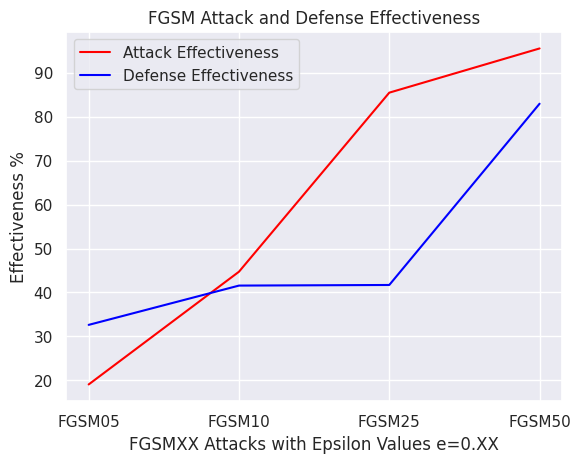

In [15]:
# Sample data
x = ["FGSM05", "FGSM10", "FGSM25", "FGSM50"]
y1 = [fgsm05_att_eff, fgsm10_att_eff, fgsm25_att_eff, fgsm50_att_eff]
y2 = [fgsm05_def_eff, fgsm10_def_eff, fgsm25_def_eff, fgsm50_def_eff]

df = pd.DataFrame({'X': x, 'Line 1': y1, 'Line 2': y2})

# Use Seaborn to plot the lines
sns.set(style="darkgrid")
sns.lineplot(x='X', y='Line 1', data=df, c="red", label='Attack Effectiveness')
sns.lineplot(x='X', y='Line 2', data=df, c="blue", label='Defense Effectiveness')

# Show the plot
plt.title("FGSM Attack and Defense Effectiveness")
plt.xlabel("FGSMXX Attacks with Epsilon Values e=0.XX")
plt.ylabel("Effectiveness %")
plt.legend()
plt.show()

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

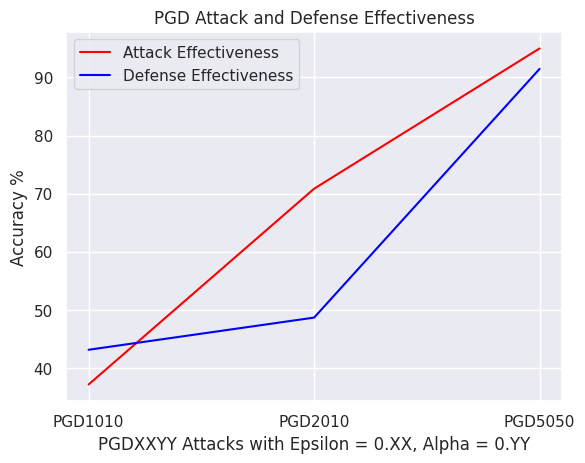

In [16]:
# Sample data
x = ["PGD1010", "PGD2010", "PGD5050"]
y1 = [pgd1010_att_eff, pgd2010_att_eff, pgd5050_att_eff]
y2 = [pgd1010_def_eff, pgd2010_def_eff, pgd5050_def_eff]

df = pd.DataFrame({'X': x, 'Line 1': y1, 'Line 2': y2})

# Use Seaborn to plot the lines
sns.set(style="darkgrid")
sns.lineplot(x='X', y='Line 1', data=df, c="red", label='Attack Effectiveness')
sns.lineplot(x='X', y='Line 2', data=df, c="blue", label='Defense Effectiveness')

# Show the plot
plt.title("PGD Attack and Defense Effectiveness")
plt.xlabel("PGDXXYY Attacks with Epsilon = 0.XX, Alpha = 0.YY")
plt.ylabel("Accuracy %")
plt.legend()
plt.show()

### Different Prompts on Same Alpha Beta Values

--------------------------------------------------
RUNNING FGSM10_P1 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 8.05%

Attacked Image Detection w/ StyleCLIP: 34.17%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 32.66%

--------------------------------------------------
RUNNING FGSM10_P2 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 6.90%

Attacked Image Detection w/ StyleCLIP: 36.18%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 34.67%

--------------------------------------------------
RUNNING FGSM10_P3 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 6.90%

Attacked Image Detection w/ StyleCLIP: 33.67%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 32.16%

--------------------------------------------------
RUNNING FGSM10_P4 DEFENSE METRICS...

Attack Effecti

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

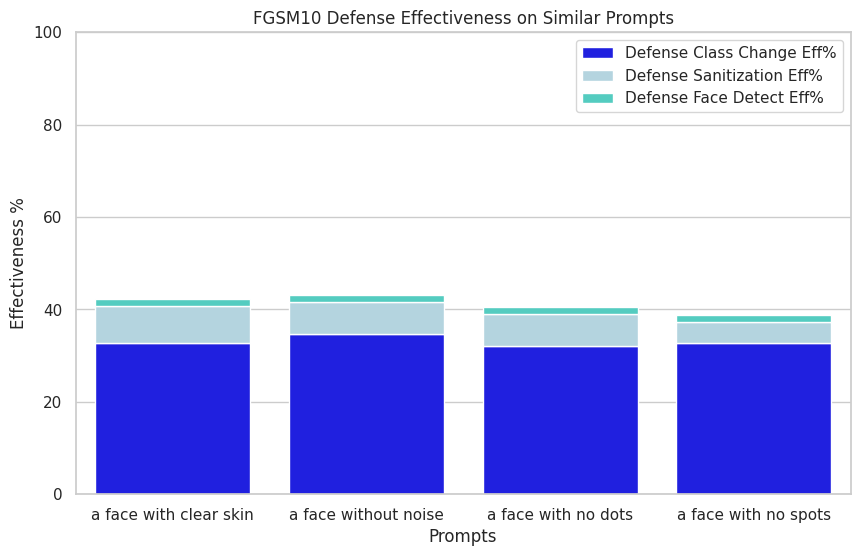

In [29]:
# Sample data

fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm10_defend_df_p1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p1.csv")
fgsm10_defend_df_p2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p2.csv")
fgsm10_defend_df_p3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p3.csv")
fgsm10_defend_df_p4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-p4.csv")

print_defense_metrics("FGSM10_P1", fgsm10_attack_df, fgsm10_defend_df_p1, fgsm10_detected_df)
print_defense_metrics("FGSM10_P2", fgsm10_attack_df, fgsm10_defend_df_p2, fgsm10_detected_df)
print_defense_metrics("FGSM10_P3", fgsm10_attack_df, fgsm10_defend_df_p3, fgsm10_detected_df)
print_defense_metrics("FGSM10_P4", fgsm10_attack_df, fgsm10_defend_df_p4, fgsm10_detected_df)

data = {
    'Category': ['a face with clear skin', 'a face without noise', 'a face with no dots', 'a face with no spots'],
    'Defense Class Change Eff%': [32.66, 34.67, 32.16, 32.66],
    'Defense Sanitization Eff%': [8.05, 6.90, 6.90, 4.60],
    'Defense Face Detect Eff%': [1.51, 1.51, 1.51, 1.51],
}

df = pd.DataFrame(data)

# Set the seaborn style
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Defense Class Change Eff%', data=df, color='blue', label='Defense Class Change Eff%')
sns.barplot(x='Category', y='Defense Sanitization Eff%', data=df, color='lightblue', label='Defense Sanitization Eff%', bottom=df['Defense Class Change Eff%'])
sns.barplot(x='Category', y='Defense Face Detect Eff%', data=df, color='turquoise', label='Defense Face Detect Eff%', bottom=df['Defense Class Change Eff%'] + df['Defense Sanitization Eff%'])
plt.legend()
plt.ylim(0, 100)

# Set plot labels and title
plt.xlabel('Prompts')
plt.ylabel('Effectiveness %')
plt.title('FGSM10 Defense Effectiveness on Similar Prompts')

# Show the plot
plt.show()

### Same Prompt on Different Alpha Beta Values

--------------------------------------------------
RUNNING FGSM10_AB1 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 6.90%

Attacked Image Detection w/ StyleCLIP: 34.67%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 33.17%

--------------------------------------------------
RUNNING FGSM10_AB2 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 6.90%

Attacked Image Detection w/ StyleCLIP: 34.17%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 32.66%

--------------------------------------------------
RUNNING FGSM10_AB3 DEFENSE METRICS...

Attack Effectiveness: 44.72%

StyleCLIP Sanitization Effectiveness (on successful attacks): 19.54%

Attacked Image Detection w/ StyleCLIP: 11.56%
	 Couldn't Detect a Face: 1.51%
	 Classification Change: 10.05%

--------------------------------------------------
RUNNING FGSM10_AB4 DEFENSE METRICS...

Attack Ef

/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/grads/hassledw/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

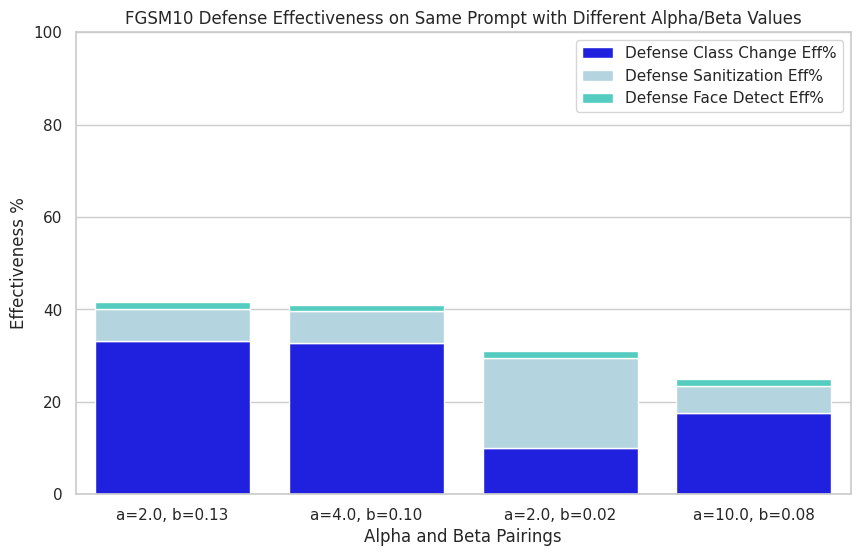

In [27]:
fgsm10_attack_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/FGSM10.csv")
fgsm10_detected_df = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-detected.csv")

fgsm10_defend_df_ab1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab1.csv")
test_defended_df_ab1 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab1.csv")
fgsm10_defend_df_ab2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab2.csv")
test_defended_df_ab2 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab2.csv")
fgsm10_defend_df_ab3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab3.csv")
test_defended_df_ab3 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab3.csv")
fgsm10_defend_df_ab4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-FGSM10-ab4.csv")
test_defended_df_ab4 = pd.read_csv("/home/grads/hassledw/StyleCLIP_Defense/CelebA_HQ-Labeled/StyleCLIP-test-ab4.csv")

print_defense_metrics("FGSM10_AB1", fgsm10_attack_df, fgsm10_defend_df_ab1, fgsm10_detected_df, test_defended_df=test_defended_df_ab1)
print_defense_metrics("FGSM10_AB2", fgsm10_attack_df, fgsm10_defend_df_ab2, fgsm10_detected_df, test_defended_df=test_defended_df_ab2)
print_defense_metrics("FGSM10_AB3", fgsm10_attack_df, fgsm10_defend_df_ab3, fgsm10_detected_df, test_defended_df=test_defended_df_ab3)
print_defense_metrics("FGSM10_AB4", fgsm10_attack_df, fgsm10_defend_df_ab4, fgsm10_detected_df, test_defended_df=test_defended_df_ab4)

# Sample data
data = {
    'Category': ['a=2.0, b=0.13', 'a=4.0, b=0.10', 'a=2.0, b=0.02', 'a=10.0, b=0.08'],
    'Defense Class Change Eff%': [33.17, 32.66, 10.05, 17.59],
    'Defense Sanitization Eff%': [6.9, 6.9, 19.54, 5.75],
    'Defense Face Detect Eff%': [1.51, 1.51, 1.51, 1.51],
}

df = pd.DataFrame(data)

# Set the seaborn style
sns.set(style="whitegrid")

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Defense Class Change Eff%', data=df, color='blue', label='Defense Class Change Eff%')
sns.barplot(x='Category', y='Defense Sanitization Eff%', data=df, color='lightblue', label='Defense Sanitization Eff%', bottom=df['Defense Class Change Eff%'])
sns.barplot(x='Category', y='Defense Face Detect Eff%', data=df, color='turquoise', label='Defense Face Detect Eff%', bottom=df['Defense Class Change Eff%'] + df['Defense Sanitization Eff%'])
plt.legend()
plt.ylim(0, 100)

# Set plot labels and title
plt.xlabel('Alpha and Beta Pairings')
plt.ylabel('Effectiveness %')
plt.title('FGSM10 Defense Effectiveness on Same Prompt with Different Alpha/Beta Values')
# Show the plot
plt.show()